In [1]:
%matplotlib inline

In [2]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mask = mock['x'] < 200
mask *= mock['y'] < 200
mask *= mock['z'] < 200
mock = mock[mask]
mock.Lbox = 200.


/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

import os
from astropy.table import Table
v4_prerelease_dirname = "/Users/aphearin/Dropbox/protoDC2/v4_prerelease"
v4_prerelease_fname = os.path.join(
    v4_prerelease_dirname, "v4_prerelease_no_interpolation.hdf5")
v4 = Table.read(v4_prerelease_fname, path='data')
print(v4.keys())

['redshift', 'mstar', 'hostHaloMass', 'isCentral', 'mag_g', 'mag_r', 'mag_i', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'Lum_g', 'Lum_r', 'Lum_i', 'disk_mag_r', 'bulge_mag_r', 'lum_tot_r', 'bulge_rhalf_arcsec', 'disk_rhalf_arcsec', 'bt', 'ang_diam_dist_Mpc', 'bulge_rhalf_kpc_phys', 'disk_rhalf_kpc_phys']


In [4]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [47]:
def remap_mag_obs(mag_obs_old, mag_abs_old, mag_abs_new):
    dmag = mag_obs_old - mag_abs_old
    mag_obs_new = dmag + mag_abs_new
    return mag_obs_new


def redshift_boost_median_magr(redshift, 
            z_table=[0, 0.25, 0.5, 1], boost_table=[0, -0.2, -0.5, -1.5], **kwargs):
    return np.interp(redshift, z_table, boost_table)


def median_magr_from_mstar(mstar, redshift, 
            beta=3.25, gamma=2.15, m1=10., magr_at_m1=-19.75, **kwargs):
    m_by_m1 = mstar/10.**m1
    denom_term1 = m_by_m1**beta
    denom_term2 = m_by_m1**gamma
    result = 1. / (denom_term1 + denom_term2)
    highz_boost = redshift_boost_median_magr(redshift, **kwargs)
    return np.log10(result*mstar) - np.log10(0.5*10**m1) + magr_at_m1 + highz_boost


def scatter_magr_from_mstar(mstar, logsm_abscissa=[6, 8, 9], 
                            scatter_ordinates=[1, 0.3, 0.15], **kwargs):
    """
    """
    return np.interp(np.log10(mstar), logsm_abscissa, scatter_ordinates)


def mc_magr_from_mstar(mstar, redshift, **kwargs):
    """
    """
    median_magr = median_magr_from_mstar(mstar, redshift, **kwargs)
    scatter_magr = scatter_magr_from_mstar(mstar, **kwargs)
    
    return np.random.normal(loc=median_magr, scale=scatter_magr)


In [48]:
v4['mag_r_new'] = mc_magr_from_mstar(v4['mstar'], v4['redshift'])
v4['mag_r_obs_new'] = remap_mag_obs(v4['mag_r_obs'], v4['mag_r'], v4['mag_r_new'])

mock['mag_r_new'] = mc_magr_from_mstar(mock['obs_sm'], np.zeros(len(mock)))


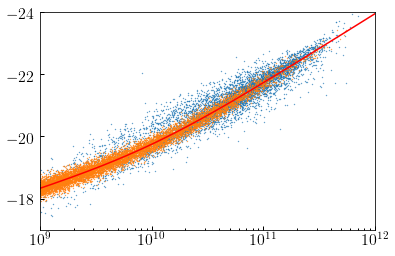

In [49]:
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

nskip = 30
__=ax.scatter(10**sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip], s=0.1)

mstar = np.logspace(5, 12, 1000)
magr = median_magr_from_mstar(mstar, 0)

# __=ax.plot(mstar, magr, color='k')
__=ax.plot(mstar, median_magr_from_mstar(mstar, 0), color='red')

nskip2 = 30
__=ax.scatter(mock['obs_sm'][::nskip2], 
              mock['mag_r_new'][::nskip2], s=0.1)

# ngals = int(1e4)
# mc_mstar = 10**np.random.uniform(5, 12, ngals)
# __=ax.scatter(mc_mstar, mc_magr_from_mstar(mc_mstar), s=0.1)

__=ax.set_ylim(-17, -24)
__=ax.set_xlim(10**9, 10**12)

In [50]:
print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile', 'mag_r_new']


## HSC cumulative LF validation test 

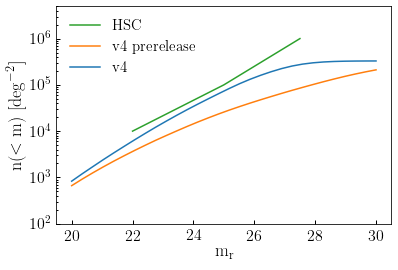

In [51]:
magarr = np.linspace(20, 30, 30)
magmasks = list((v4['mag_r_obs'] < m) for m in magarr)
counts = np.array([np.count_nonzero(mask) for mask in magmasks])
magmasks_new = list((v4['mag_r_obs_new'] < m) for m in magarr)
counts_new = np.array([np.count_nonzero(mask) for mask in magmasks_new])

sky_area = 25.
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')

hsc_ordinates = [1e4, 1e5, 1e6]
hsc_abscissa = [22, 25, 27.5]
__=ax.plot(hsc_abscissa, hsc_ordinates, label=r'${\rm HSC}$', color=mgreen)

__=ax.plot(magarr, counts/sky_area, label=r'${\rm v4\ prerelease}$', color=morange)
__=ax.plot(magarr, counts_new/sky_area, label=r'${\rm v4}$', color=mblue)

xlabel = ax.set_xlabel(r'${\rm m_{r}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e2, 5e6)


## Compare cumulative number density to Zehavi+11

In [52]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4 = cumulative_nd(mock['mag_r_new'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


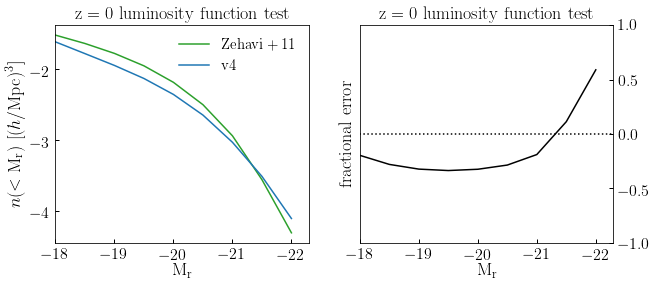

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), 
            label=r'${\rm v4}$', color=mblue)

fracdiff_pdc2_v4 = (cumnd_pdc2_v4 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4, 
            label=r'${\rm v4}$', color='k')
__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm z=0\ luminosity\ function\ test}$')
title2 = ax2.set_title(r'${\rm z=0\ luminosity\ function\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-18, -22.3)
ylim2 = ax2.set_ylim(-1, 1)


In [10]:

# def abs_mag_boost(mstar, logsm_table=[6, 8, 9.5], boost_table=[-10, -3, 0]):
#     return np.interp(np.log10(mstar), logsm_table, boost_table)

# boost = abs_mag_boost(v4['mstar'])
# v4['mag_r_new'] = v4['mag_r'] + boost
# v4['mag_r_obs_new'] = remap_mag_obs(v4['mag_r_obs'], v4['mag_r'], v4['mag_r_new'])

# fig, ax = plt.subplots(1, 1)

# nskip=500
# __=ax.scatter(v4['mag_r'][::nskip], 
#               v4['mag_r_new'][::nskip]-v4['mag_r'][::nskip], s=0.1)

# xlim = ax.set_xlim(-10, -23)

In [11]:
# fig, ax = plt.subplots(1, 1)

# nskip=500
# __=ax.scatter(np.log10(v4['mstar'][::nskip]), v4['mag_r'][::nskip], s=0.1)

# ylim = ax.set_ylim(-10, -24)

In [12]:
# fig, ax = plt.subplots(1, 1)

# nskip=500
# __=ax.scatter(np.log10(v4['mstar'][::nskip]), v4['mag_r'][::nskip], s=0.1)

# xlim = ax.set_xlim(5.5, 12)
# ylim = ax.set_ylim(-10, -23)
